# Labeled Faces In The Wild Deep Learning Classification


## Desription

The LFW (Labeled Faces In The Wild) dataset is composed of 5479 clases (different persons) for more than 13000 images.

## Initialization

In [9]:
# IMSIZE = [250, 250, 3]

## Load dataset

In [10]:
from sklearn.datasets import fetch_lfw_people

# Load dataset in color mode with centered on the faces
lfw_people = fetch_lfw_people(min_faces_per_person=10, color=True, resize=1.0,
                              slice_=(slice(70, 195), slice(78, 172)), funneled=True)

X = lfw_people.data
y = lfw_people.target

target_names = lfw_people.target_names
n_classes = target_names.shape[0]
n_samples, h, w, l = lfw_people.images.shape

# Reshape images 1D array to images matrix
X = X.reshape(-1, h, w, l).astype('uint8')

## Show images infos

In [11]:
print(target_names)
print(f"Image dimensions: {w}x{h}x{l}")
print(f"Number of classes: {n_classes}")
print(f"Number of samples: {n_samples}")

['Abdullah Gul' 'Adrien Brody' 'Alejandro Toledo' 'Alvaro Uribe'
 'Amelie Mauresmo' 'Andre Agassi' 'Andy Roddick' 'Angelina Jolie'
 'Ann Veneman' 'Anna Kournikova' 'Ari Fleischer' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Atal Bihari Vajpayee' 'Bill Clinton'
 'Bill Gates' 'Bill McBride' 'Bill Simon' 'Britney Spears' 'Carlos Menem'
 'Carlos Moya' 'Catherine Zeta-Jones' 'Charles Moose' 'Colin Powell'
 'Condoleezza Rice' 'David Beckham' 'David Nalbandian' 'Dick Cheney'
 'Dominique de Villepin' 'Donald Rumsfeld' 'Edmund Stoiber'
 'Eduardo Duhalde' 'Fidel Castro' 'George HW Bush' 'George Robertson'
 'George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo'
 'Gonzalo Sanchez de Lozada' 'Gordon Brown' 'Gray Davis' 'Guillermo Coria'
 'Halle Berry' 'Hamid Karzai' 'Hans Blix' 'Harrison Ford'
 'Hillary Clinton' 'Howard Dean' 'Hu Jintao' 'Hugo Chavez' 'Ian Thorpe'
 'Igor Ivanov' 'Jack Straw' 'Jackie Chan' 'Jacques Chirac' 'Jacques Rogge'
 'James Blake' 'James Kelly' 'Jason Kidd' 'Javier Solana'

## Show images

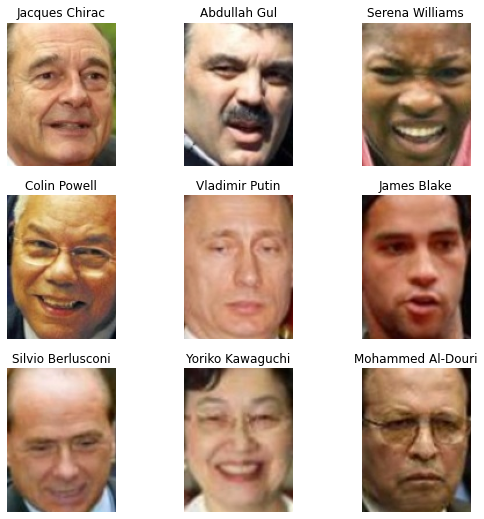

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i])
    plt.title(target_names[y[i]])
    plt.axis("off")
plt.show()

## Split dataset

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building model


In [14]:
from tensorflow import keras
from keras.optimizers import SGD
from keras import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.applications import ResNet50

batch_size = 8
epochs = 50
number_of_last_layers_trainable = 10
learning_rate = 0.001
nesterov = True
momentum = 0.9

preprocess_input = keras.applications.resnet.preprocess_input

model = ResNet50(
    input_shape=[h, w, 3],
    weights="imagenet",
    include_top=False,
    classes=n_classes,
)

for layer in model.layers[: number_of_last_layers_trainable]:
    layer.trainable = False

out = model.output

x = Flatten()(out)
x = Dense(n_classes, activation="softmax")(x)

model = Model(inputs=model.input, outputs=x)

opti = SGD(
    learning_rate=learning_rate,
    momentum=momentum,
    nesterov=nesterov,
)

# model.compile(loss="sparse_categorical_crossentropy", optimizer=opti, metrics=["accuracy"])

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opti, metrics=["accuracy"])
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 125, 94, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 131, 100, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 63, 47, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 63, 47, 64)   256         ['conv1_conv[0][0]']       

## Data augmentation

In [15]:
from keras_preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.05,
    shear_range=10,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.20,
    preprocessing_function=preprocess_input,
)

train_generator = image_gen.flow(
    x=X_train,
    y=y_train,
    shuffle=True,
    batch_size=batch_size,
)

test_generator = image_gen.flow(
    x=X_test,
    y=y_test,
    shuffle=True,
    batch_size=batch_size,
)

## Training

In [20]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", patience=2)
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=epochs,
                    callbacks=[early_stop])

Epoch 1/50
433/433 [==============================] - 25s 57ms/step - loss: 0.1458 - accuracy: 0.9566 - val_loss: 1.2809 - val_accuracy: 0.7353
Epoch 2/50
433/433 [==============================] - 25s 58ms/step - loss: 0.1310 - accuracy: 0.9639 - val_loss: 1.3569 - val_accuracy: 0.7237
Epoch 3/50
433/433 [==============================] - 26s 60ms/step - loss: 0.1220 - accuracy: 0.9639 - val_loss: 1.0653 - val_accuracy: 0.7665
Epoch 4/50
433/433 [==============================] - 27s 61ms/step - loss: 0.0978 - accuracy: 0.9714 - val_loss: 1.0353 - val_accuracy: 0.7572
Epoch 5/50
433/433 [==============================] - 26s 60ms/step - loss: 0.0776 - accuracy: 0.9766 - val_loss: 1.1089 - val_accuracy: 0.7815
Epoch 6/50
433/433 [==============================] - 29s 66ms/step - loss: 0.0637 - accuracy: 0.9818 - val_loss: 1.0153 - val_accuracy: 0.7977
Epoch 7/50
433/433 [==============================] - 27s 62ms/step - loss: 0.0774 - accuracy: 0.9798 - val_loss: 0.9865 - val_accuracy:

## Save model

In [17]:
model.save_weights("../weights/resnet50_lfw.h5")

## Prediction test

In [24]:
image_index = 100
y_pred_mytest = model.predict(X[image_index:image_index + 9])

1/1 [==============================] - 0s 34ms/step


## Prediction display

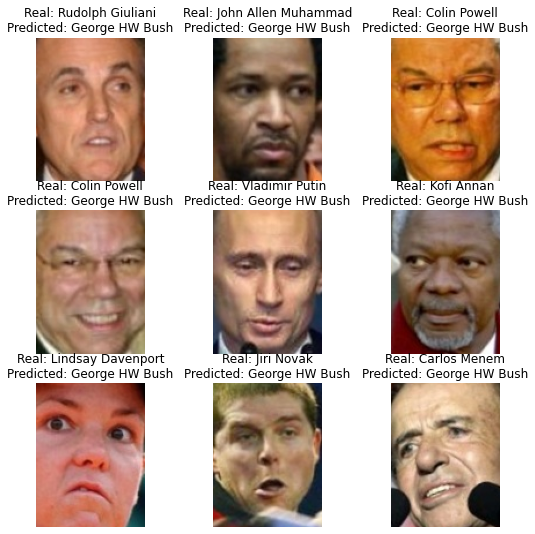

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    text = f"Real: {target_names[y[image_index + i]]}\nPredicted: {target_names[np.argmax(y_pred_mytest[i])]}"
    plt.title(text)
    plt.imshow(X[image_index + i])
    plt.axis("off")
plt.show()
